# Asteroid 1 / PHA 이진분류

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#전처리
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import KBinsDiscretizer

# 매개변수 그리드
from sklearn.model_selection import GridSearchCV

# 특성 선택
from sklearn.feature_selection import SelectFromModel

#
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, pos_label="Y")


#파이프라인
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# 성능 평가
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#overSampling
from imblearn.over_sampling import SMOTE

# model
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1zdaujvrEHpei8_MIr5RRq-uA6LsCVCzZ/view?usp=sharing' # The shareable link
#fluff, id = link.split('=')
#print (id) # Verify that you have everything after '='
id = '1zdaujvrEHpei8_MIr5RRq-uA6LsCVCzZ'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('results.csv')  


### About Data

In [3]:
datas = pd.read_csv('results.csv')
datas.info()

# 특성과 데이터 타입

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079619 entries, 0 to 1079618
Data columns (total 21 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   name      22183 non-null    object 
 1   neo       1079617 non-null  object 
 2   pha       1069004 non-null  object 
 3   H         1075633 non-null  float64
 4   diameter  139999 non-null   float64
 5   albedo    138848 non-null   float64
 6   rot_per   32577 non-null    float64
 7   spec_B    1666 non-null     object 
 8   e         1079619 non-null  float64
 9   a         1079619 non-null  float64
 10  q         1079619 non-null  float64
 11  i         1079619 non-null  float64
 12  om        1079619 non-null  float64
 13  w         1079619 non-null  float64
 14  ma        1079618 non-null  float64
 15  ad        1079617 non-null  float64
 16  n         1079619 non-null  float64
 17  tp        1079619 non-null  float64
 18  per       1079617 non-null  float64
 19  moid      1069004 non

In [ ]:
datas.head()

,name,neo,pha,H,diameter,albedo,rot_per,spec_B,e,a,q,i,om,w,ma,ad,n,tp,per,moid,class
0,Ceres,N,N,3.53,939.400,0.0900,9.074170,C,0.078168,2.766089,2.549868,10.587899,80.272358,73.724889,205.545416,2.982310,0.214242,2.459921e+06,1680.341973,1.58537,MBA
1,Pallas,N,N,4.21,545.000,0.1010,7.813200,B,0.229750,2.774382,2.136967,34.854459,172.965884,310.288113,187.586351,3.411796,0.213282,2.460009e+06,1687.903980,1.23487,MBA
2,Juno,N,N,5.26,246.596,0.2140,7.210000,Sk,0.256988,2.668020,1.982370,12.991482,169.853044,248.032767,170.711246,3.353669,0.226162,2.458446e+06,1591.776184,1.03316,MBA
3,Vesta,N,N,3.29,525.400,0.4228,5.342128,V,0.088425,2.362030,2.153168,7.141653,103.808335,150.922482,258.567830,2.570893,0.271504,2.459574e+06,1325.948229,1.13933,MBA
4,Astraea,N,N,6.99,106.699,0.2740,16.806000,S,0.190788,2.573621,2.082605,5.367534,141.571702,358.625009,65.612382,3.064636,0.238719,2.458926e+06,1508.048333,1.09563,MBA


- 이름: 개체 IAU 이름
- NEO: NEO(Near-Earth Object) 플래그
- PHA: 잠재적으로 위험한 소행성(PHA) 플래그
- H: 절대 진도 매개변수
- diameter: 물체 직경(등가 구에서) km 단위
- albedo : 기하학적 알베도
- rot_per : 회전 주기
- spec_B : 스펙트럼
- e: 편심
- a: 반주축 au 단위
- q: 주변 거리 au 단위
- i: 경사, x-y 촉각 평면에 대한 각도
- tp: 영구 통로 TDB 단위 시간
- moid: 지구 최소 궤도 교차로 거리 au 단위
- class : 소행성 궤도 등급

- name: Object IAU name
- NEO: Near-Earth Object (NEO) flag
- PHA: Potentially Hazardous Asteroid (PHA) flag
- H: Absolute magnitude parameter
- Diameter: object diameter (from equivalent sphere) km Unit
- Albedo: Geometric albedo
- rot_per : rotation period
- spec_B : spectrum
- e: Eccentricity
- a: Semi-major axis au Unit
- q: perihelion distance au Unit
- i: inclination; angle with respect to x-y ecliptic plane
- tp: Time of perihelion passage TDB Unit
- moid: Earth Minimum Orbit Intersection Distance au Unit
- class : asteroid orbit class

In [ ]:
datas.shape

(1079619, 21)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdec53c0a10>,
      dtype=object)

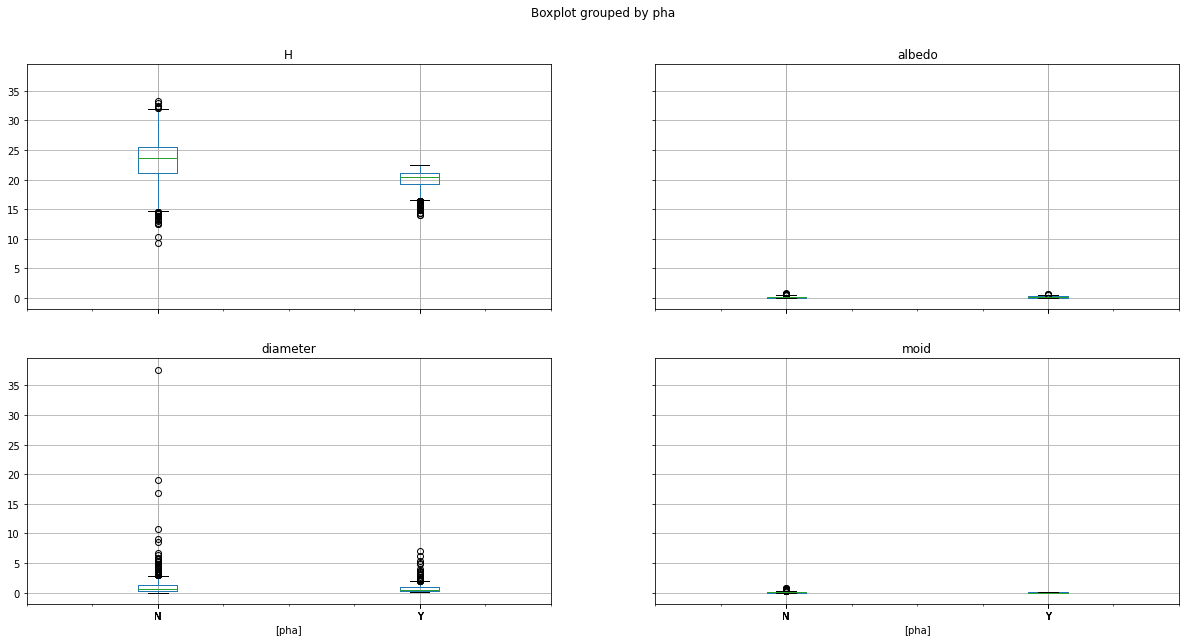

In [ ]:
datas[['H', 'moid', 'albedo', 'diameter', 'pha']].boxplot(by='pha', figsize=(20,10))

#H값이 pha=Y일 경우 조금 더 작은 분포를 가짐

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdec5079e50>,
      dtype=object)

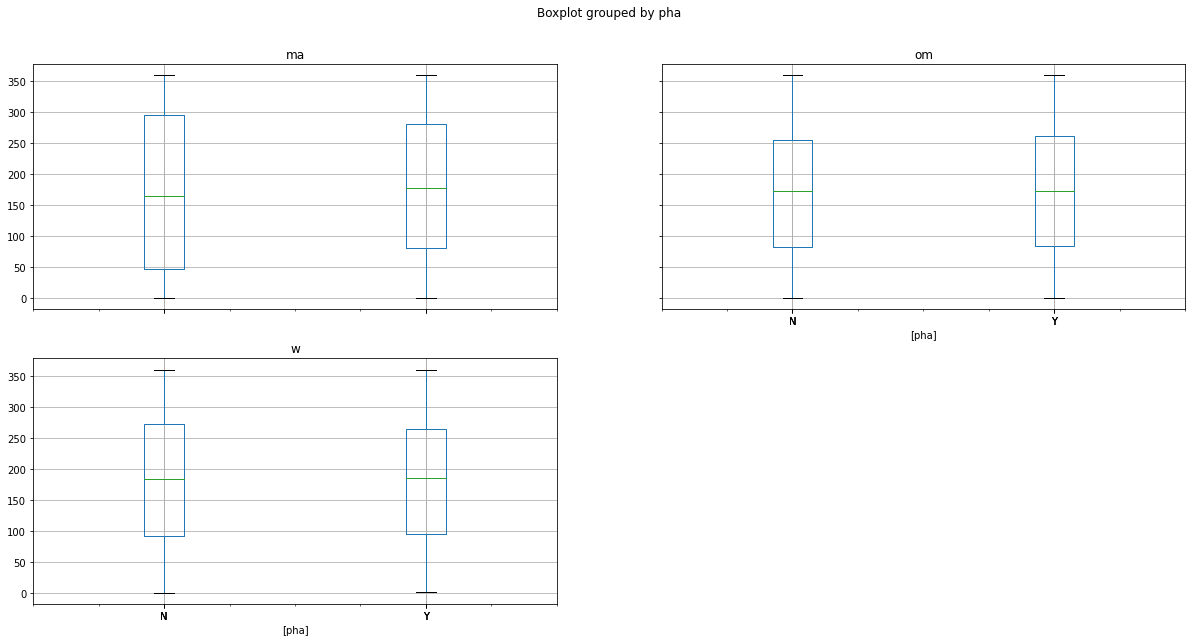

In [ ]:
datas[['om', 'w', 'ma', 'pha']].boxplot(by='pha', figsize=(20,10))

# om w ma는 비슷함

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


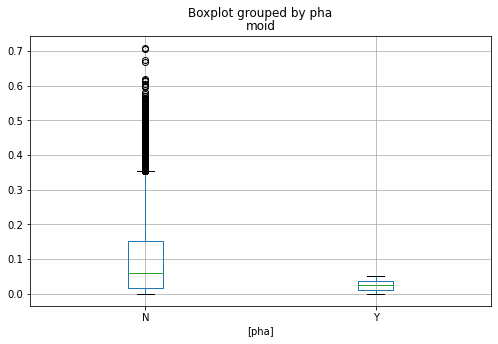

In [ ]:

datas[[ 'moid', 'pha']].boxplot(by='pha', figsize=(8,5))

# moid 역시 Y일 경우 더 작은 분포

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


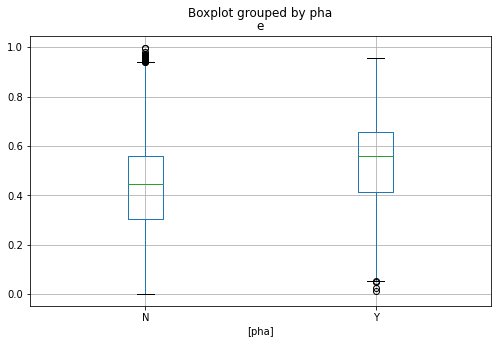

In [ ]:
datas[['e', 'pha']].boxplot(by='pha', figsize=(8,5))

# e는 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


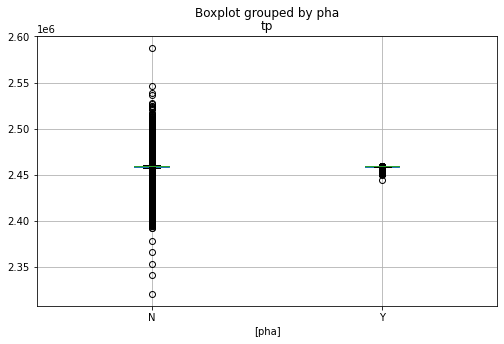

In [ ]:
datas[['tp', 'pha']].boxplot(by='pha', figsize=(8,5))


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


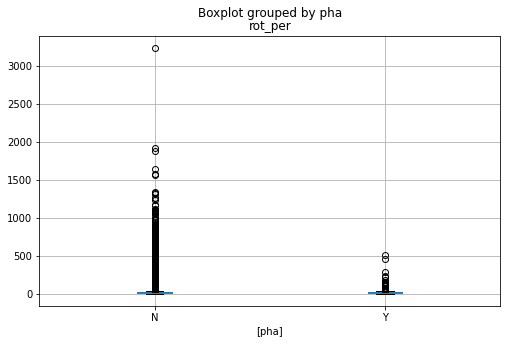

In [ ]:
datas[['rot_per', 'pha']].boxplot(by='pha', figsize=(8,5))


In [ ]:


print(datas.pha.value_counts())
# pha빈도수

print(datas[datas.neo=='Y'].pha.value_counts())
# neo = 'y' 조건 적용 후 빈도수

# neo = 'y' 적용 후 pha='Y' 데이터는 살리고 N 데이터는 축소

N    1066841
Y       2163
Name: pha, dtype: int64
N    23564
Y     2163
Name: pha, dtype: int64


In [ ]:
datas.isnull().sum()

# 결측치 확인

name        1057436
neo               2
pha           10615
H              3986
diameter     939620
albedo       940771
rot_per     1047042
spec_B      1077953
e                 0
a                 0
q                 0
i                 0
om                0
w                 0
ma                1
ad                2
n                 0
tp                0
per               2
moid          10615
class             0
dtype: int64

In [ ]:
datas[datas.neo=='Y'].isnull().sum()

# 사전조건 후 결측치 확인

name        25566
neo             0
pha             1
H               7
diameter    24477
albedo      24522
rot_per     23910
spec_B      25415
e               0
a               0
q               0
i               0
om              0
w               0
ma              0
ad              0
n               0
tp              0
per             0
moid            1
class           0
dtype: int64

### 데이터 전처리

In [4]:
phas = datas[datas.neo=='Y']
# neo = 'Y'로 사전 조건을 적용하여 데이터 셋을 축소
print(phas.shape)

phas = phas.dropna(subset=['pha'])
phas = phas.dropna(subset=['H'])
phas = phas.dropna(subset=['moid'])
print(phas.shape)
# 결측치가 있는 row 버리기


X = phas.drop('pha', axis=1)
# 타겟값으로 쓸 pha 특성 버리기

y = phas['pha']
# 타겟값

X = X.drop(['name', 'diameter', 'albedo', 'rot_per', 'spec_B', 'neo'], axis=1)
# 데이터가 거의 결측치인 5가지 특성 버림

(25728, 21)
(25720, 21)


In [7]:
X_drops = X.drop(['moid', 'H'], axis=1)

In [ ]:
columns = X.columns
columns

# 남은 특성들

Index(['H', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'tp', 'per',
       'moid', 'class'],
      dtype='object')

In [ ]:
print(X.shape)
print(y.shape)

# 거의 결측치인 특성 7개와 소수의 결측치만 있는 것들 행 지우기

(25720, 14)
(25720,)


In [ ]:
y.value_counts()

In [5]:
ct = make_column_transformer((OneHotEncoder(), ['class']),   #클래스는 OHE로  처리
                            (StandardScaler(), ['H', 'e', 'a', 'q', 'i', 'om', 'w', 'ma','ad', 'n', 'tp', 'per', 'moid']))  # 연속형 변수들은 스탠다드 스케일러로 처리

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
#훈련 데이터와 테스트 데이터로 나눔

X_train_trans = ct.fit_transform(X_train)
X_test_trans = ct.transform(X_test)
# 데이터 전처리 / ohe + scaling


In [8]:
ct = make_column_transformer((OneHotEncoder(), ['class']),   #클래스는 OHE로  처리
                            (StandardScaler(), ['e', 'a', 'q', 'i', 'om', 'w', 'ma','ad', 'n', 'tp', 'per']))  # 연속형 변수들은 스탠다드 스케일러로 처리

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_drops,y,random_state=0)
#훈련 데이터와 테스트 데이터로 나눔

X_train_transd = ct.fit_transform(X_train)
X_test_transd = ct.transform(X_test)
# 데이터 전처리 / ohe + scaling


### 모델 적용

In [ ]:
rf = RandomForestClassifier(random_state=0).fit(X_train_transd, y_train)
rf.score(X_test_transd, y_test)

0.9172628304821151

In [ ]:
confusion_matrix(y_test, rf.predict(X_test_transd))

array([[5890,   16],
       [ 516,    8]])

In [ ]:
print(X_train.shape)
print(X_test.shape)

print(X_train_trans.shape)
print(X_test_trans.shape)

# 클래스 특성 1개에서 4개로 늘어나 특성이 3개 더 생김

(19295, 14)
(6432, 14)
(19295, 17)
(6432, 17)


In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

# 11 : 1 정도의 분포

N    17651
Y     1639
Name: pha, dtype: int64
N    5906
Y     524
Name: pha, dtype: int64


In [ ]:
# svc 기본값으로 테스트

svm = SVC(random_state=0).fit(X_train_trans, y_train)
print(svm.score(X_test_trans, y_test))

# OHE + StandardScaler

0.9743390357698289


In [ ]:
print(confusion_matrix(y_test, svm.predict(X_test_trans)))

# 정확도는 높지만 데이터가 불균형하여 실제로는 pha=y에 대한 구분이 제대로 이루어지지 않음

[[5846   60]
 [ 105  419]]


In [ ]:
print(classification_report(y_test, svm.predict(X_test_trans)))

              precision    recall  f1-score   support

           N       0.98      0.99      0.99      5906
           Y       0.87      0.80      0.84       524

    accuracy                           0.97      6430
   macro avg       0.93      0.89      0.91      6430
weighted avg       0.97      0.97      0.97      6430



In [10]:
ct_ori = make_column_transformer((OneHotEncoder(), ['class']),
                            remainder='passthrough')   #클래스는 OHE로  처리
X_train_ori = ct_ori.fit_transform(X_train)
X_test_ori = ct_ori.transform(X_test)


svm_ori = SVC(random_state=0).fit(X_train_ori, y_train)
print(svm_ori.score(X_test_ori, y_test))

# OHE
# 스케일링 X
# 스케일링에 영향을 받는 모델이라서 점수가 조금 떨어짐


0.91850699844479


In [ ]:
print(confusion_matrix(y_test, svm_ori.predict(X_test_ori)))
print(classification_report(y_test, svm_ori.predict(X_test_ori)))

[[5906    0]
 [ 524    0]]
              precision    recall  f1-score   support

           N       0.92      1.00      0.96      5906
           Y       0.00      0.00      0.00       524

    accuracy                           0.92      6430
   macro avg       0.46      0.50      0.48      6430
weighted avg       0.84      0.92      0.88      6430



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
smote = SMOTE(random_state=0, sampling_strategy=0.3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_ori, y_train)

# smote 오버샘플링
# sampling_strategy = 비율
# 무작위성 제어를 위하여 RandomState 설정



print(X_train_smote.shape)

print(y_train.value_counts())
print(pd.DataFrame(y_train_smote).value_counts())

# 설정한 비율에 맞춰서 1639 -> 5295로 오버 샘플링 됐음

(22946, 17)
N    17651
Y     1639
Name: pha, dtype: int64
N    17651
Y     5295
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
svm_smote = SVC(random_state=0).fit(X_train_smote, y_train_smote)
print(svm_smote.score(X_test_ori, y_test))

0.91850699844479


In [ ]:
confusion_matrix(y_test, svm_smote.predict(X_test_ori))


array([[5906,    0],
       [ 524,    0]])

In [ ]:
scaler = StandardScaler()

X_train_smote_trans = scaler.fit_transform(X_train_smote)
svm_smote_trans = SVC(random_state=0, C=10, gamma=0.1).fit(X_train_smote_trans, y_train_smote)


print(svm_smote.score(X_test_trans, y_test))
confusion_matrix(y_test, svm_smote_trans.predict(X_test_trans))


0.91850699844479


array([[5530,  376],
       [  16,  508]])

준비한 훈련/테스트 데이터 셋

- X_trans -> OHE + StandardScaling
- X_ori - > OHE
- X_smote -> X_ori + smote
- X_smote_trans -> X_trans + smote

In [ ]:
# 매개변수 그리드 적용
# C와 gamma값으로 실행

pipe = make_pipeline(
    StandardScaler(),
    SVC(random_state=0)
)

pipe.steps

[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('svc',
  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
      verbose=False))]

In [ ]:

param_grid = { 
              'svc__C' : [0.001, 0.01, 0.1, 1, 10,100],
             'svc__gamma': [ 0.001, 0.01, 0.1, 1, 10,100],
             }

grid_search = GridSearchCV(pipe, param_grid, cv=5)

In [ ]:
grid_search.fit(X_train_ori, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False, random_state=0,
                                            shrinking=True, tol=0.001,
                                     

In [ ]:

print("테스트 세트 점수 : ", grid_search.score(X_test_ori, y_test))
print("최적 매개변수 ", grid_search.best_params_)
print("최적 교차 검증 점수 ", grid_search.best_score_)
print("최적 성능 모델 ", grid_search.best_estimator_)


테스트 세트 점수 :  0.9810264385692068
최적 매개변수  {'svc__C': 100, 'svc__gamma': 0.1}
최적 교차 검증 점수  0.9800933125972005
최적 성능 모델  Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=100, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.1, kernel='rbf', max_iter=-1, probability=False,
                     random_state=0, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


In [ ]:
res = pd.DataFrame(grid_search.cv_results_)
display(np.transpose(res.head()))

,0,1,2,3,4
mean_fit_time,2.14321,2.14793,2.15391,2.13202,2.26815
std_fit_time,0.0114803,0.00664139,0.0195552,0.00961066,0.0149451
mean_score_time,0.417671,0.421417,0.416,0.42589,0.45348
std_score_time,0.00377326,0.00900424,0.0021512,0.00253056,0.00921615
param_svc__C,0.001,0.001,0.001,0.001,0.001
param_svc__gamma,0.001,0.01,0.1,1,10
params,"{'svc__C': 0.001, 'svc__gamma': 0.001}","{'svc__C': 0.001, 'svc__gamma': 0.01}","{'svc__C': 0.001, 'svc__gamma': 0.1}","{'svc__C': 0.001, 'svc__gamma': 1}","{'svc__C': 0.001, 'svc__gamma': 10}"
split0_test_score,0.915241,0.915241,0.915241,0.915241,0.915241
split1_test_score,0.914982,0.914982,0.914982,0.914982,0.914982
split2_test_score,0.914982,0.914982,0.914982,0.914982,0.914982


(6, 6)


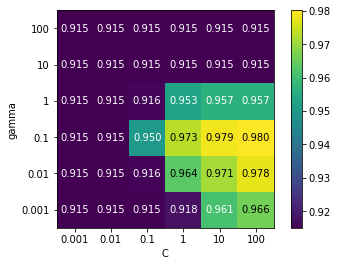

In [ ]:
import mglearn
scores = grid_search.cv_results_['mean_test_score'].reshape(-1,6).T

print(scores.shape)
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", cmap='viridis', fmt='%.3f',
    ylabel="gamma",
    xticklabels=param_grid['svc__C'],
    yticklabels=param_grid['svc__gamma']
)
 
plt.colorbar(heatmap)


In [ ]:
print(confusion_matrix(y_test, grid_search.predict(X_test_ori)))

[[5854   52]
 [  70  454]]


In [ ]:
print(classification_report(y_test, grid_search.predict(X_test_ori)))


              precision    recall  f1-score   support

           N       0.99      0.99      0.99      5906
           Y       0.90      0.87      0.88       524

    accuracy                           0.98      6430
   macro avg       0.94      0.93      0.94      6430
weighted avg       0.98      0.98      0.98      6430



In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    SVC(random_state=0)
)

grid_search_f1 = GridSearchCV(pipe, param_grid, cv=5, scoring=f1_scorer)
grid_search_f1.fit(X_train_ori, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False, random_state=0,
                                            shrinking=True, tol=0.001,
                                     

In [ ]:

print("테스트 세트 점수 : ", grid_search_f1.score(X_test_ori, y_test))
print("최적 매개변수 ", grid_search_f1.best_params_)
print("최적 교차 검증 점수 ", grid_search_f1.best_score_)
print("최적 성능 모델 ", grid_search_f1.best_estimator_)

# scoring = 'accuracy' 와 같은 결과! 
# f1-score은 재현율과 정밀도를 모두 반영함


# f1 점수

테스트 세트 점수 :  0.8815533980582525
최적 매개변수  {'svc__C': 100, 'svc__gamma': 0.1}
최적 교차 검증 점수  0.881566769580932
최적 성능 모델  Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=100, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.1, kernel='rbf', max_iter=-1, probability=False,
                     random_state=0, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


In [ ]:
print(confusion_matrix(y_test, grid_search_f1.predict(X_test_ori)))


[[5854   52]
 [  70  454]]


In [11]:
rf = RandomForestClassifier(random_state=0).fit(X_train_ori, y_train)
rf.score(X_test_ori, y_test)

0.9979782270606532

In [12]:
print(confusion_matrix(y_test, rf.predict(X_test_ori)))


[[5900    6]
 [   7  517]]


In [ ]:
from sklearn.model_selection import cross_validate

X_dum = pd.get_dummies(X)
y = y

cvs = cross_validate(rf, X_dum, y, cv=10, return_train_score=True, return_estimator=True)
print(cvs)

In [20]:
display(pd.DataFrame(cvs))

,fit_time,score_time,estimator,test_score,train_score
0,3.567343,0.035970,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.999222,1.0
1,3.456891,0.034999,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.998834,1.0
2,3.301106,0.032142,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.997278,1.0
3,3.335798,0.031823,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.995334,1.0
4,3.292951,0.031222,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.997278,1.0
5,3.397442,0.031919,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.998056,1.0
6,3.384703,0.033141,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.997667,1.0
7,3.455195,0.032161,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.996112,1.0
8,3.321582,0.032478,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.996890,1.0
9,3.410846,0.032104,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.998056,1.0


In [39]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
X_dum = np.array(X_dum)
y = np.array(y)
rf = RandomForestClassifier(random_state=0)

for train,test in skf.split(X_dum,y):
  rf.fit(X_dum[train], y[train])
  print(confusion_matrix(y[test], rf.predict(X_dum[test])), end='')
  print('\n')



[[2353    3]
 [   3  213]]

[[2350    6]
 [   1  215]]

[[2351    5]
 [   2  214]]

[[2351    5]
 [   2  214]]

[[2350    6]
 [   3  213]]

[[2352    4]
 [   3  213]]

[[2354    2]
 [   2  214]]

[[2350    5]
 [   1  216]]

[[2354    1]
 [   5  212]]

[[2354    1]
 [   1  216]]



In [40]:

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
X_dum = np.array(X_dum)
y = np.array(y)
xg = XGBClassifier(random_state=0)

for train,test in skf.split(X_dum,y):
  xg.fit(X_dum[train], y[train])
  print(confusion_matrix(y[test], xg.predict(X_dum[test])), end='')
  print('\n')



[[2354    2]
 [   4  212]]

[[2352    4]
 [   2  214]]

[[2352    4]
 [   3  213]]

[[2354    2]
 [   2  214]]

[[2351    5]
 [   3  213]]

[[2353    3]
 [   3  213]]

[[2354    2]
 [   3  213]]

[[2352    3]
 [   1  216]]

[[2354    1]
 [   6  211]]

[[2354    1]
 [   1  216]]



In [ ]:

print(classification_report(y_test, rf.predict(X_test_ori)))

              precision    recall  f1-score   support

           N       1.00      1.00      1.00      5906
           Y       0.99      0.99      0.99       524

    accuracy                           1.00      6430
   macro avg       0.99      0.99      0.99      6430
weighted avg       1.00      1.00      1.00      6430



In [ ]:
# 중요도 함수
def plot_feature_importances(model, X, fea):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), fea)
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)
    plt.xlim(0,1)
    plt.grid()

['class' 'class' 'class' 'class' 'H' 'e' 'a' 'q' 'i' 'om' 'w' 'ma' 'ad'
 'n' 'tp' 'per' 'moid']


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_

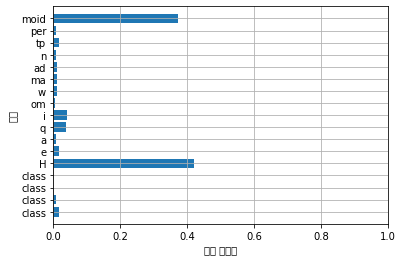

In [ ]:
features = np.hstack([['class', 'class','class', 'class'],columns[:13]])
print(features)

plot_feature_importances(rf, X_train_ori, features)

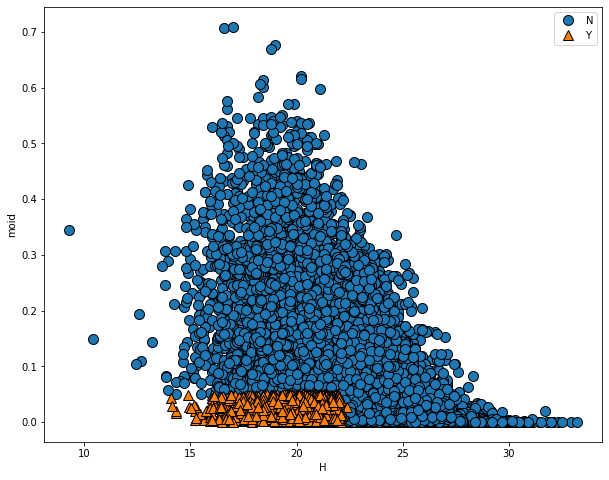

In [ ]:
import mglearn
plt.figure(figsize=(10,8))
mglearn.discrete_scatter(X_train['H'], X_train['moid'], y_train)
plt.xlabel("H")
plt.ylabel("moid")
plt.legend()

In [ ]:
X_test_ori[:10, :4]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
from xgboost import XGBClassifier

xg = XGBClassifier(random_state=0).fit(X_train_ori, y_train)
xg.score(X_test_ori, y_test)

0.9979782270606532

In [ ]:
print(confusion_matrix(y_test, xg.predict(X_test_ori)))

[[5900    6]
 [   7  517]]


In [ ]:
# 매개변수 그리드 적용
# C와 gamma값으로 실행

pipe = make_pipeline(
    StandardScaler(),
    XGBClassifier()
)

param_grid_xg = { 'xgbclassifier__learning_rate' : [0.01, 0.1, 1] ,
                'xgbclassifier__max_depth' : [3, 5, 7]
                 }

grid_search_xg = GridSearchCV(pipe, param_grid_xg, cv=5)
grid_search_xg.fit(X_train_ori, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                      

In [ ]:

print("테스트 세트 점수 : ", grid_search_xg.score(X_test_ori, y_test))
print("최적 매개변수 ", grid_search_xg.best_params_)
print("최적 교차 검증 점수 ", grid_search_xg.best_score_)

print("최적 성능 모델 ", grid_search_xg.best_estimator_)

테스트 세트 점수 :  0.9979782270606532
최적 매개변수  {'xgbclassifier__learning_rate': 1, 'xgbclassifier__max_depth': 3}
최적 교차 검증 점수  0.9975635044064282
최적 성능 모델  Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],


In [ ]:
print(confusion_matrix(y_test, grid_search_xg.predict(X_test_ori)))
print(classification_report(y_test, grid_search_xg.predict(X_test_ori)))

[[5900    6]
 [   7  517]]
              precision    recall  f1-score   support

           N       1.00      1.00      1.00      5906
           Y       0.99      0.99      0.99       524

    accuracy                           1.00      6430
   macro avg       0.99      0.99      0.99      6430
weighted avg       1.00      1.00      1.00      6430



In [ ]:
mlp = MLPClassifier(random_state=0).fit(X_train_trans, y_train)
print(mlp.score(X_test_trans, y_test))

# 거의 완벽한 예측..

0.9959564541213064


In [ ]:
mlp_10 = MLPClassifier(hidden_layer_sizes=(10,10), random_state=0).fit(X_train_trans, y_train)
print(mlp_10.score(X_test_trans, y_test))
# 같은 정확도

0.9962674961119751


In [ ]:
mlp_ori = MLPClassifier(random_state=0).fit(X_train_ori, y_train)
print(mlp_ori.score(X_test_ori, y_test))

# 전처리 영향을 받음

0.91850699844479


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
print(confusion_matrix(y_test, mlp.predict(X_test_trans)))
#다른 결과..

[[5893   13]
 [  13  511]]


In [ ]:
print(confusion_matrix(y_test, mlp_10.predict(X_test_trans)))
#

[[5893   13]
 [  11  513]]


In [ ]:
mlp_10_10 = MLPClassifier(hidden_layer_sizes=(100,10), random_state=0).fit(X_train_trans, y_train)
print(mlp_10_10.score(X_test_trans, y_test))
# 같은 정확도

0.9951788491446345


In [ ]:
print(confusion_matrix(y_test, mlp_10_10.predict(X_test_trans)))
#

[[5898    8]
 [  23  501]]


In [ ]:
lr = LogisticRegression( max_iter=3000).fit(X_train_trans, y_train)

print(lr.score(X_test_trans, y_test))

0.9656298600311042


In [ ]:
print(confusion_matrix(y_test, lr.predict(X_test_trans)))
#

[[5819   87]
 [ 134  390]]


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(include_bias=False)

X_train_poly = pf.fit_transform(X_train_trans)
X_test_poly = pf.transform(X_test_trans)

lr = LogisticRegression( max_iter=3000).fit(X_train_poly, y_train)

print(lr.score(X_test_poly, y_test))

0.9860031104199067


In [ ]:
print(confusion_matrix(y_test, lr.predict(X_test_poly)))
#

[[5867   39]
 [  51  473]]


(-5.0, 5.0)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text

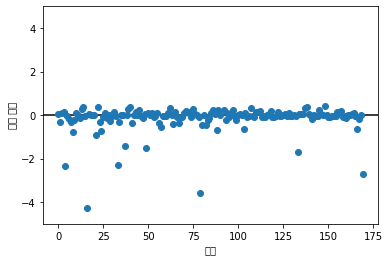

In [ ]:
plt.plot(lr.coef_.T, 'o')
    
plt.xlabel("특성")
plt.ylabel("계수 크기")

xlimes = plt.xlim()
plt.hlines(0,xlimes[0], xlimes[1])
plt.xlim(xlimes)
plt.ylim(-5,5)


In [ ]:
# 매개변수 그리드 적용
pipe = make_pipeline(
    PolynomialFeatures(include_bias=False),
    StandardScaler(),
    LogisticRegression(max_iter=3000)
)

param_grid_lr = { 
               'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10, 100]
                }

grid_search_lr = GridSearchCV(pipe, param_grid = param_grid_lr, cv=5)
grid_search_lr

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=False,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
          

In [ ]:
grid_search_lr.fit(X_train_ori, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=False,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
          

In [ ]:

print("테스트 세트 점수 : ", grid_search_lr.score(X_test_ori, y_test))
print("최적 매개변수 ", grid_search_lr.best_params_)
print("최적 교차 검증 점수 ", grid_search_lr.best_score_)
print("최적 성능 모델 ", grid_search_lr.best_estimator_)

테스트 세트 점수 :  0.9905132192846035
최적 매개변수  {'logisticregression__C': 100}
최적 교차 검증 점수  0.9886469673405911
최적 성능 모델  Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=3000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [ ]:
print(confusion_matrix(y_test, grid_search_lr.predict(X_test_ori)))
#

[[5876   30]
 [  31  493]]


(-5.0, 5.0)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text

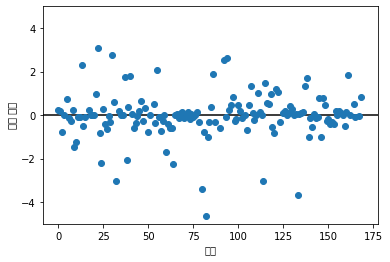

In [ ]:

plt.plot(grid_search_lr.best_estimator_.named_steps['logisticregression'].coef_.T, 'o')
    
plt.xlabel("특성")
plt.ylabel("계수 크기")

xlimes = plt.xlim()
plt.hlines(0,xlimes[0], xlimes[1])
plt.xlim(xlimes)
plt.ylim(-5,5)


In [ ]:
selector = SelectFromModel(LogisticRegression(max_iter=5000)).fit(X_train_poly, y_train)

selector.get_support()

array([False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False,  True,  True, False,  True, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False,  True,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False,  True, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
X_train_fea = selector.transform(X_train_poly)

lr_fe = LogisticRegression(max_iter=5000).fit(X_train_fea, y_train)

In [ ]:
X_test_fea = selector.transform(X_test_poly)
lr_fe.score(X_test_fea, y_test)

0.9878693623639191

In [ ]:
print(confusion_matrix(y_test, lr_fe.predict(X_test_fea)))

[[5873   33]
 [  45  479]]


In [ ]:
# 매개변수 그리드 적용
#pipe = make_pipeline(
#   PolynomialFeatures(include_bias=False),
#   SelectFromModel(LogisticRegression(), 
#   StandardScaler(),
#    LogisticRegression(max_iter=3000)
#)

pipeline = Pipeline([ 
    ('preprocessing', PolynomialFeatures(include_bias=False)),
    ('feature_selection', SelectFromModel(LogisticRegression(max_iter=5000))),
    ('scaling', StandardScaler()),
    ('estimator', LogisticRegression(max_iter=5000))
     ])    

param_grid_lr = { 
               'estimator__C' : [0.001, 0.01, 0.1, 1, 10, 100]
                }

grid_search_lr = GridSearchCV(pipeline, param_grid = param_grid_lr, cv=5)
grid_search_lr

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=False,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LogisticRegression(C=1.0,
                                                                                     class_weight=None,
                                                                                     dual=False,
                                                                                     fit_intercept=True,
                                                                                     intercept_scali

In [ ]:
grid_search_lr.fit(X_train_ori, y_train)

In [ ]:

print("테스트 세트 점수 : ", grid_search_lr.score(X_test_ori, y_test))
print("최적 매개변수 ", grid_search_lr.best_params_)
print("최적 교차 검증 점수 ", grid_search_lr.best_score_)
print("최적 성능 모델 ", grid_search_lr.best_estimator_)


테스트 세트 점수 :  0.9905132192846035
최적 매개변수  {'estimator__C': 100}
최적 교차 검증 점수  0.9886469673405911
최적 성능 모델  Pipeline(memory=None,
         steps=[('preprocessing',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('feature_selection',
                 SelectFromModel(estimator=LogisticRegression(C=1.0,
                                                              class_weight=None,
                                                              dual=False,
                                                              fit_intercept=True,
                                                              intercept_scaling=1,
                                                              l1_ratio=None,
                                                              max_iter=5000,
                                                              multi_class='auto',
                                     

[[5876   30]
 [  31  493]]


(-5.0, 5.0)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text

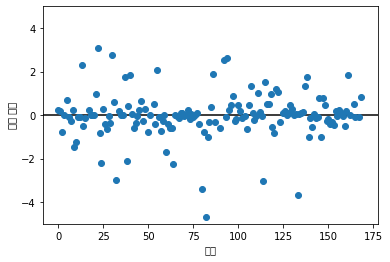

In [ ]:
print(confusion_matrix(y_test, grid_search_lr.predict(X_test_ori)))
#

plt.plot(grid_search_lr.best_estimator_.named_steps['estimator'].coef_.T, 'o')
    
plt.xlabel("특성")
plt.ylabel("계수 크기")

xlimes = plt.xlim()
plt.hlines(0,xlimes[0], xlimes[1])
plt.xlim(xlimes)
plt.ylim(-5,5)


In [ ]:
grid_search_lr.best_estimator_.named_steps['feature_selection'].get_support()


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
grid_search_lr.best_estimator_.named_steps['estimator']


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
X = pd.get_dummies(X)
y = y

In [ ]:
X.head()

,H,e,a,q,i,om,w,ma,ad,n,tp,per,moid,class_AMO,class_APO,class_ATE,class_IEO
432,10.40,0.222994,1.458167,1.133005,10.830513,304.299134,178.868934,23.041748,1.783330,0.559749,2.459159e+06,643.145790,0.148573,1,0,0,0
718,15.51,0.546721,2.638378,1.195922,11.570400,183.858330,156.191216,186.243081,4.080833,0.229985,2.459956e+06,1565.322585,0.201325,1,0,0,0
886,13.84,0.570422,2.473534,1.062575,9.393848,110.433729,350.512508,345.243765,3.884493,0.253354,2.459259e+06,1420.938219,0.081753,1,0,0,0
1035,9.30,0.533095,2.665194,1.244392,26.676143,215.544210,132.378538,50.117961,4.085995,0.226522,2.458979e+06,1589.247561,0.343891,1,0,0,0
1220,17.39,0.435488,1.919166,1.083392,11.880444,171.316487,26.677583,112.664864,2.754939,0.370711,2.458897e+06,971.106980,0.106469,1,0,0,0


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
rf = RandomForestClassifier(random_state=0)
cs = cross_validate(rf, X, y, cv=5, return_estimator=True)

display(cs)

{'estimator': (RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
                         n_jobs=None, oob_score=False, random_state=0, verbose=0,
                         warm_start=False),
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimat

In [ ]:
cs['test_score']

array([0.99902799, 0.99630638, 0.99727838, 0.99650078, 0.99747278])

In [ ]:
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=0)
cs = cross_val_score(xg, X, y, cv=5)

print(cs)

[0.99902799 0.99669518 0.99766719 0.99688958 0.99708398]
